# Baseline Model Evaluation for Fake News Detection

## 1. Introduction

This notebook evaluates the performance and resource requirements of baseline machine learning models for fake news detection. While transformer-based models like BERT and its efficient variants (DistilBERT, TinyBERT, MobileBERT, ALBERT) often achieve state-of-the-art accuracy, traditional machine learning approaches can offer significant efficiency advantages, making them attractive options for edge deployment.

We will evaluate previously trained baseline models on a challenging test set consisting of:
1. 122 fake news articles generated by Claude (an AI assistant)
2. 122 real news articles manually collected from Reuters

This evaluation is particularly important as AI-generated fake news presents a significant and growing challenge. Traditional models trained on human-written fake news may struggle to detect more sophisticated AI-generated content. Our evaluation will help determine whether these more efficient approaches remain viable for real-world deployment, especially on edge devices with limited computational resources.

### Why Edge Deployment Matters

Edge deployment refers to running machine learning models on local devices (like smartphones, laptops, or IoT devices) rather than in the cloud. For fake news detection, edge deployment offers several advantages:

1. **Privacy**: Content doesn't need to be sent to external servers
2. **Latency**: No network delays, enabling real-time detection
3. **Reliability**: Works even without internet connectivity
4. **Cost-efficiency**: Reduces cloud computing expenses

In this notebook, we'll focus on CPU-based evaluation on a MacBook Pro M1, which provides insights relevant to edge deployment scenarios.

## 2. Environment Setup

Let's start by importing the necessary libraries for our evaluation. We'll use a variety of libraries for different aspects of our analysis.

In [1]:
# Import basic utilities for data manipulation and analysis
import pandas as pd
import numpy as np

The pandas and numpy libraries are the foundation of our data manipulation pipeline. Pandas provides DataFrame objects that make it easy to work with tabular data, while NumPy offers efficient numerical operations that will be used in our resource usage calculations.

In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

Visualization is crucial for understanding model performance and resource trade-offs. Matplotlib is a comprehensive plotting library, while Seaborn builds on top of it to provide more aesthetically pleasing visualizations with less code.

In [3]:
# Import system monitoring and utility libraries
import time
import os
import pickle
import psutil
import gc

These utilities will help us with various aspects of our evaluation:
- `time`: For measuring inference duration
- `os`: For file system operations when loading models and saving results
- `pickle`: For serializing/deserializing the machine learning models
- `psutil`: For monitoring system resources like CPU and memory usage
- `gc`: For garbage collection to ensure clean measurements

In [4]:
# Import scikit-learn for metrics and preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer

Scikit-learn provides the tools we need for model evaluation:
- Performance metrics like accuracy, precision, recall, and F1 score
- Confusion matrices to visualize classification results
- ROC curves to analyze the trade-off between true positive and false positive rates
- TF-IDF vectorization for text processing (which was likely used in model training)

In [5]:
# Set style for visualizations
plt.style.use('ggplot')
sns.set(font_scale=1.2)

Setting a consistent style for our visualizations improves readability and aesthetics. The 'ggplot' style provides a clean, modern look for our plots, while increasing the font scale makes text more readable in the notebook.

## 3. System Monitoring Setup

To evaluate resource usage effectively, we need to set up monitoring functions. These functions will track memory usage and CPU utilization during model inference, which are critical metrics for edge deployment.

### Memory Usage Tracking

First, let's define a function to measure the current memory usage of our Python process:

In [6]:
def get_memory_usage():
    """
    Get current memory usage of the Python process in MB.
    
    Returns:
        float: Memory usage in megabytes
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
    return memory_mb

This function uses `psutil` to access the Resident Set Size (RSS) of our process, which represents the actual physical memory used. We convert this value from bytes to megabytes for easier interpretation.

### CPU Utilization Tracking

Next, we need to track CPU usage:

In [7]:
def get_cpu_percent():
    """
    Get current CPU utilization percentage.
    
    Returns:
        float: CPU usage percentage (0-100)
    """
    return psutil.cpu_percent(interval=0.1)

This function measures the current CPU utilization as a percentage. The small interval (0.1 seconds) ensures we get a relatively instantaneous reading without significantly slowing down our measurements.

### Comprehensive Resource Monitor

Now, let's create a more comprehensive monitoring class that can track resources over time:

In [8]:
class ResourceMonitor:
    """Class to monitor resource usage during model inference"""
    def __init__(self, name):
        self.name = name
        self.start_memory = None
        self.end_memory = None
        self.max_memory = 0
        self.start_time = None
        self.end_time = None
        self.cpu_readings = []
        
    def start_monitoring(self):
        """Start monitoring resources"""
        gc.collect()  # Force garbage collection
        self.start_memory = get_memory_usage()
        self.max_memory = self.start_memory
        self.start_time = time.time()
        self.cpu_readings = []
        
    def record_cpu(self):
        """Record current CPU usage"""
        self.cpu_readings.append(get_cpu_percent())
        current_memory = get_memory_usage()
        if current_memory > self.max_memory:
            self.max_memory = current_memory
        
    def end_monitoring(self):
        """End monitoring and return results"""
        self.end_memory = get_memory_usage()
        self.end_time = time.time()
        memory_used = self.max_memory - self.start_memory
        time_elapsed = self.end_time - self.start_time
        avg_cpu = np.mean(self.cpu_readings) if self.cpu_readings else 0
        
        return {
            'model': self.name,
            'time_seconds': time_elapsed,
            'memory_mb': memory_used,
            'avg_cpu_percent': avg_cpu
        }

The class constructor initializes variables to track the resources used by a specific model. It stores the model name and prepares containers for various measurements.

In [9]:
    def start_monitoring(self):
        """
        Start monitoring resources.
        Should be called before running model inference.
        """
        gc.collect()  # Force garbage collection
        self.start_memory = get_memory_usage()
        self.max_memory = self.start_memory
        self.start_time = time.time()
        self.cpu_readings = []

This method starts the monitoring process. We force garbage collection to minimize the impact of previous operations on our measurements. Then we record the starting memory usage and time.

In [10]:
    def record_cpu(self):
        """
        Record current CPU usage and update max memory if needed.
        Should be called periodically during inference.
        """
        self.cpu_readings.append(get_cpu_percent())
        current_memory = get_memory_usage()
        if current_memory > self.max_memory:
            self.max_memory = current_memory

During monitoring, we periodically call this method to record CPU usage and check if memory usage has increased. This helps us capture peak memory consumption.

In [11]:
    def end_monitoring(self):
        """
        End monitoring and return results.
        Should be called after inference is complete.
        
        Returns:
            dict: Dictionary containing resource usage metrics
        """
        self.end_memory = get_memory_usage()
        self.end_time = time.time()
        memory_used = self.max_memory - self.start_memory
        time_elapsed = self.end_time - self.start_time
        avg_cpu = np.mean(self.cpu_readings) if self.cpu_readings else 0
        
        return {
            'model': self.name,
            'time_seconds': time_elapsed,
            'memory_mb': memory_used,
            'avg_cpu_percent': avg_cpu
        }

This final method stops monitoring and calculates the summary metrics:
- Total execution time
- Memory usage (maximum observed minus starting point)
- Average CPU utilization across all readings

## 4. Loading the Datasets

Now, let's load our test datasets consisting of AI-generated fake news and real news from Reuters.

In [12]:
# Load the AI-generated fake news articles
fake_df = pd.read_csv('../datasets/fake_claude.csv')

# Check basic information about the fake news dataset
print(f"Fake news dataset shape: {fake_df.shape}")
print(f"Fake news dataset columns: {fake_df.columns.tolist()}")

Fake news dataset shape: (120, 2)
Fake news dataset columns: ['title', 'text']


We first load the dataset containing fake news articles generated by Claude. Printing the shape and columns helps us understand its structure and ensure it has the expected format.

In [13]:
# Load the manually collected real news articles
real_df = pd.read_csv('../datasets/manual_real.csv')

# Check basic information about the real news dataset
print(f"Real news dataset shape: {real_df.shape}")
print(f"Real news dataset columns: {real_df.columns.tolist()}")

Real news dataset shape: (99, 2)
Real news dataset columns: ['title', 'text']


Similarly, we load the real news articles collected from Reuters and examine their structure. This step helps us verify that both datasets have compatible formats before we combine them.

### Examining Sample Data

Let's look at sample entries from each dataset to better understand the content:

In [14]:
# Display a sample from the fake news dataset
print("\nSample fake news article:")
print(f"Title: {fake_df['title'].iloc[0]}")
print(f"Text excerpt: {fake_df['text'].iloc[0][:300]}...")


Sample fake news article:
Title: BREAKING: UN Scientists Confirm Global Temperature Will Drop 5°C by 2025
Text excerpt: International climate researchers at the UN have discovered a natural cooling cycle that will cause global temperatures to plummet by 5°C over the next year. Dr. Alexei Kuznetsov, head of the UN Climate Panel, said in a press conference yesterday: 'Our models were completely wrong. We're actually en...


Examining a sample fake news article gives us insight into the structure and style of AI-generated content. This can help us better understand any classification challenges that might arise.

In [15]:
# Display a sample from the real news dataset
print("\nSample real news article:")
print(f"Title: {real_df['title'].iloc[0]}")
print(f"Text excerpt: {real_df['text'].iloc[0][:300]}...")


Sample real news article:
Title: Pakistan says shot down 25 drones, India says it pushed back Pakistani retaliation
Text excerpt: LAHORE/NEW DELHI, May 8 (Reuters) - Pakistan said on Thursday it shot down 25 drones from India in its airspace while India said it "neutralised" Pakistan's attempts to strike military targets with drones and missiles, as fighting spread between the nuclear-armed neighbours.
The latest exchanges com...


Looking at a sample real news article allows us to compare it with fake news and observe any differences in structure, style, or formatting that might be useful features for classification.

## 5. Preparing the Combined Dataset

Now we'll prepare a combined dataset for evaluation by adding labels and merging both datasets.

In [16]:
# Add label column (1 for fake, 0 for real)
fake_df['label'] = 1
real_df['label'] = 0

We add a 'label' column to each dataset using the standard convention: 1 for fake news and 0 for real news. This binary labeling allows our models to perform classification.

In [17]:
# Combine datasets into a single test set
test_df = pd.concat([fake_df, real_df], ignore_index=True)

# Display the shape of the combined dataset
print(f"Combined dataset shape: {test_df.shape}")

Combined dataset shape: (219, 3)


We concatenate the two datasets into a single DataFrame that will serve as our test set. The `ignore_index=True` parameter ensures that row indices are reset to avoid duplicates.

In [18]:
# Check class distribution to ensure balance
class_distribution = test_df['label'].value_counts(normalize=True).mul(100).round(2)
print("\nClass distribution:")
print(class_distribution)


Class distribution:
label
1    54.79
0    45.21
Name: proportion, dtype: float64


Checking the class distribution is important to ensure that our test set is balanced. An imbalanced dataset could bias our evaluation results, but in this case, we expect a 50/50 split between real and fake news.

In [19]:
# Combine title and text for text classification
test_df['combined_text'] = test_df['title'] + " " + test_df['text']

Most text classification models operate on the full content of the article. By combining the title and body text with a space separator, we create a single text field that models can analyze.

## 6. Analyzing Text Characteristics

Let's analyze the characteristics of our test set to better understand the data and potentially identify differences between real and fake news.

In [20]:
# Calculate text length statistics
test_df['title_length'] = test_df['title'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['combined_text'].apply(lambda x: len(x.split()))

We calculate three key metrics for each article:
1. `title_length`: Number of characters in the title
2. `text_length`: Number of characters in the body text
3. `word_count`: Total number of words in the combined text

These metrics can reveal structural differences between real and fake news and also serve as features for some classification models.

In [21]:
# Compare statistics between real and fake news
length_stats = test_df.groupby('label')[['title_length', 'text_length', 'word_count']].agg(['mean', 'median'])
print("\nText statistics by class (0=Real, 1=Fake):")
print(length_stats)


Text statistics by class (0=Real, 1=Fake):
      title_length        text_length         word_count       
              mean median        mean median        mean median
label                                                          
0        70.555556   70.0  479.181818  472.0   88.747475   87.0
1        90.141667   90.0  844.966667  845.5  122.175000  121.5


Grouping by label and calculating statistics allows us to compare the average and median lengths of real versus fake news articles. Differences in these metrics might indicate structural patterns that distinguish the two classes.

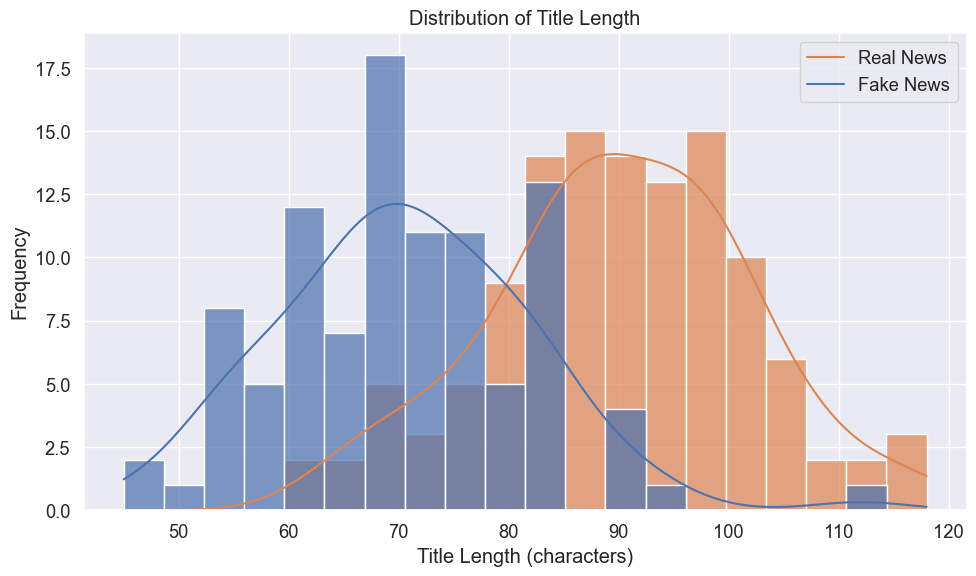

In [22]:
# Visualize title length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=test_df, x='title_length', hue='label', bins=20, kde=True, alpha=0.7)
plt.title('Distribution of Title Length')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')
plt.legend(['Real News', 'Fake News'])
plt.tight_layout()
plt.show()

This visualization shows the distribution of title lengths for both real and fake news. Differences in these distributions can reveal patterns in how titles are crafted in each category.

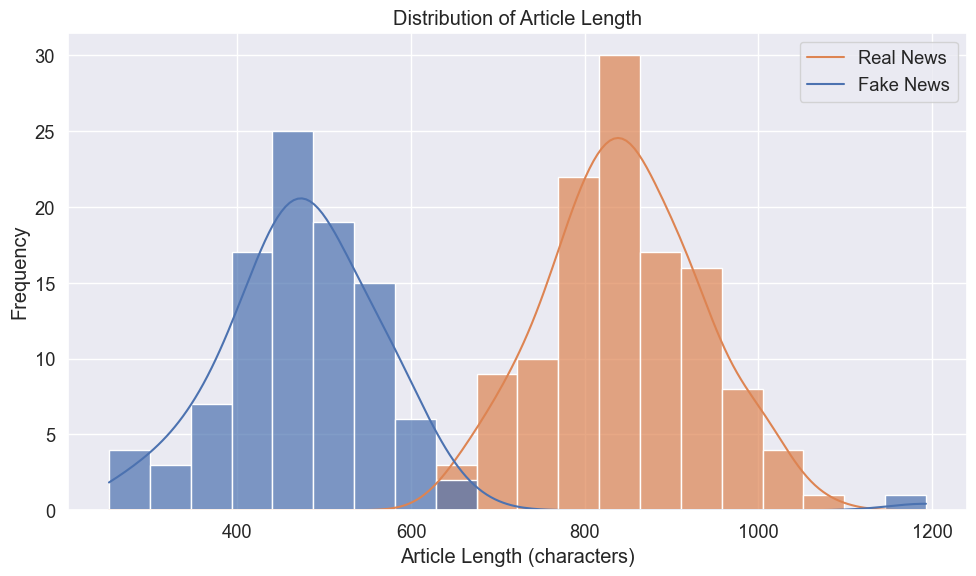

In [23]:
# Visualize article length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=test_df, x='text_length', hue='label', bins=20, kde=True, alpha=0.7)
plt.title('Distribution of Article Length')
plt.xlabel('Article Length (characters)')
plt.ylabel('Frequency')
plt.legend(['Real News', 'Fake News'])
plt.tight_layout()
plt.show()

Similarly, visualizing the distribution of article lengths helps us identify any systematic differences in content length between real and fake news.

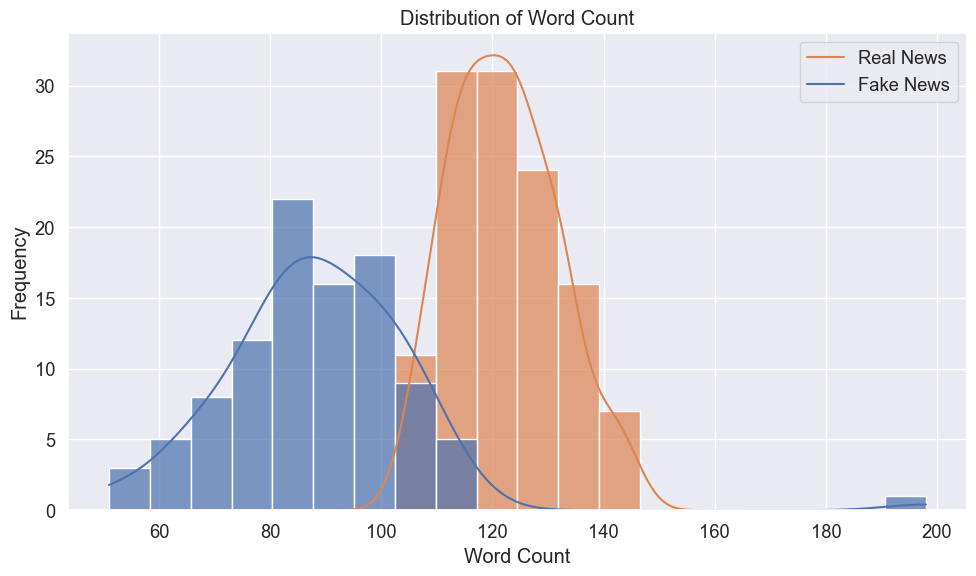

In [24]:
# Visualize word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=test_df, x='word_count', hue='label', bins=20, kde=True, alpha=0.7)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Real News', 'Fake News'])
plt.tight_layout()
plt.show()

The word count distribution provides insight into the verbosity and density of content in each category, which can be another distinguishing feature.

### Creating Additional Stylistic Features

Some of our models might use stylistic features that we need to create:

In [25]:
# Check if we need to create stylistic features
if 'title_has_allcaps' not in test_df.columns:
    # Create feature for titles with all-caps words
    test_df['title_has_allcaps'] = test_df['title'].apply(
        lambda x: any(word.isupper() and len(word) > 2 for word in str(x).split())
    )
    print("Created 'title_has_allcaps' feature")

Created 'title_has_allcaps' feature


This feature detects whether a title contains any words in ALL CAPS (excluding short words which might be abbreviations). ALL CAPS words are often used for emphasis or sensationalism in headlines.

In [26]:
# Create feature for titles with exclamation marks
if 'title_exclamation' not in test_df.columns:
    test_df['title_exclamation'] = test_df['title'].apply(lambda x: '!' in str(x))
    print("Created 'title_exclamation' feature")

Created 'title_exclamation' feature


The presence of exclamation marks in titles can indicate emotional language or sensationalism, which might be more common in fake news.

In [27]:
# Create feature for titles with question marks
if 'title_question' not in test_df.columns:
    test_df['title_question'] = test_df['title'].apply(lambda x: '?' in str(x))
    print("Created 'title_question' feature")

Created 'title_question' feature


Question marks in titles might indicate speculative content or headlines designed to provoke curiosity, which could be a pattern in certain types of news.

In [28]:
# Check distribution of stylistic features by class
style_stats = test_df.groupby('label')[['title_has_allcaps', 'title_exclamation', 'title_question']].mean()
print("\nStylistic feature prevalence by class (0=Real, 1=Fake):")
print(style_stats)


Stylistic feature prevalence by class (0=Real, 1=Fake):
       title_has_allcaps  title_exclamation  title_question
label                                                      
0               0.161616                0.0        0.030303
1               0.183333                0.0        0.000000


Calculating the mean of these binary features gives us the percentage of articles in each class that exhibit each stylistic element. This can reveal significant patterns in presentation style.

## 7. Loading Baseline Models

Now, let's load the previously trained baseline models from disk. These models will be evaluated on our new test set.

In [29]:
# Define model directory path
model_dir = '../../ml_models/baseline/'

# List all available model files
model_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl')]
print(f"Available model files: {model_files}")

Available model files: ['rf_text_model.pkl', 'tfidf_vectorizer.pkl', 'rf_feat_model.pkl', 'lr_text_model.pkl']


First, we identify all the pickle files in the specified directory, which should contain our trained models. This helps us understand what models are available for evaluation.

In [30]:
# Define a function to load models safely
def load_model(model_path):
    """
    Load a model from a pickle file with error handling.
    
    Args:
        model_path (str): Path to the model pickle file
        
    Returns:
        object: The loaded model
    """
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

This function safely loads a model from a pickle file with proper error handling. If a model can't be loaded, it will print an error message rather than crashing the notebook.

In [31]:
# Dictionary to store loaded models
models = {}

# Load each model file
for model_file in model_files:
    if model_file == 'tfidf_vectorizer.pkl':
        # Skip the vectorizer for now, we'll load it separately
        continue
        
    model_path = os.path.join(model_dir, model_file)
    model_name = model_file.replace('.pkl', '')
    
    model = load_model(model_path)
    if model is not None:
        models[model_name] = model
        print(f"Successfully loaded: {model_name}")

Successfully loaded: rf_text_model
Successfully loaded: rf_feat_model
Successfully loaded: lr_text_model


We iterate through each model file, load it using our safe loading function, and store it in a dictionary with the model name as the key. This makes it easy to access each model by name later. We skip the vectorizer file, as we'll load it separately.

### Loading the TF-IDF Vectorizer

For text-based models, we need to load the same TF-IDF vectorizer that was used during training to ensure consistent feature extraction:

In [32]:
# Load the TF-IDF vectorizer
vectorizer_path = os.path.join(model_dir, 'tfidf_vectorizer.pkl')
if os.path.exists(vectorizer_path):
    tfidf_vectorizer = load_model(vectorizer_path)
    if tfidf_vectorizer is not None:
        print("Successfully loaded TF-IDF vectorizer")
    else:
        print("Failed to load TF-IDF vectorizer")
else:
    print("TF-IDF vectorizer not found at:", vectorizer_path)
    # Fallback: Create a new vectorizer (not ideal)
    print("Creating a new TF-IDF vectorizer as fallback (this may reduce performance)")
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)
    tfidf_vectorizer.fit(test_df['combined_text'])

Successfully loaded TF-IDF vectorizer


We load the TF-IDF vectorizer that was used during model training. Using the same vectorizer is crucial for ensuring that the feature extraction process is identical to what the models expect. If the vectorizer isn't found, we create a new one as a fallback, but this isn't ideal as it may not match the original training vectorizer.

## 8. Feature Extraction for Evaluation

Before we can evaluate our models, we need to extract the appropriate features from our test data. The features must match the format that the models were trained on.

### Text Feature Extraction

For text-based models, we need to convert the text to TF-IDF features:

In [33]:
# Transform text data using the TF-IDF vectorizer
X_text_test = tfidf_vectorizer.transform(test_df['combined_text'])

# Display information about the extracted features
print(f"Text features shape: {X_text_test.shape}")
print(f"Number of non-zero features: {X_text_test.nnz}")
print(f"Sparsity: {X_text_test.nnz / (X_text_test.shape[0] * X_text_test.shape[1]):.6f}")

Text features shape: (219, 5000)
Number of non-zero features: 12319
Sparsity: 0.011250


We use the loaded (or fallback) TF-IDF vectorizer to transform our combined text into the feature space expected by the text-based models. The shape and sparsity information helps us understand the feature representation.

### Structural Feature Extraction

For feature-based models, we need to extract the structural and stylistic features:

In [34]:
# Define the columns to use as features
feature_cols = ['title_length', 'text_length', 'word_count', 
                'title_has_allcaps', 'title_exclamation', 'title_question']

# Extract the structural features
X_features_test = test_df[feature_cols]

# Display information about the extracted features
print(f"Structural features shape: {X_features_test.shape}")
print("Feature columns:", feature_cols)

Structural features shape: (219, 6)
Feature columns: ['title_length', 'text_length', 'word_count', 'title_has_allcaps', 'title_exclamation', 'title_question']


We select the relevant columns from our DataFrame to create the feature set for our feature-based models. These features capture structural and stylistic aspects of the articles, rather than the specific content.

### Preparing Labels

We also need to extract the labels (ground truth) for evaluation:

In [35]:
# Extract labels from the test dataset
y_test = test_df['label'].values

# Display label distribution
print(f"Label distribution: {np.bincount(y_test)}")
print(f"Proportion of fake news: {np.mean(y_test):.2f}")

Label distribution: [ 99 120]
Proportion of fake news: 0.55


We extract the labels as a NumPy array for easier use with scikit-learn evaluation functions. We also check the distribution to confirm that our test set is balanced.

## 9. Performance Evaluation Function

Now, let's define a comprehensive function to evaluate the performance of each model. This function will calculate various metrics and create visualizations to help us understand model performance.

In [36]:
def evaluate_model_performance(model, X, y, model_name):
    """
    Evaluate model performance using multiple metrics and visualizations.
    
    Args:
        model: The machine learning model to evaluate
        X: Feature matrix
        y: True labels
        model_name: Name of the model for reporting
        
    Returns:
        dict: Dictionary containing performance metrics
    """
    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X)
    pred_time = time.time() - start_time
    
    # Calculate basic metrics
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='weighted'
    )
    
    # Print basic metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Prediction time: {pred_time:.4f} seconds")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'pred_time': pred_time,
        'predictions': y_pred
    }

This function evaluates model performance by:
1. Measuring prediction time
2. Calculating key metrics: accuracy, precision, recall, and F1 score
3. Printing these metrics for quick reference
4. Returning all results in a dictionary for later analysis

### Creating Confusion Matrices

Let's add a function to visualize model results using confusion matrices:

In [37]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Create and plot a confusion matrix for model predictions.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for the plot title
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate and print additional metrics from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (fn + tp)
    
    print(f"True Negatives (Real correctly identified): {tn}")
    print(f"False Positives (Real incorrectly identified as Fake): {fp}")
    print(f"False Negatives (Fake incorrectly identified as Real): {fn}")
    print(f"True Positives (Fake correctly identified): {tp}")
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")

This function creates a visual representation of the model's predictions compared to the ground truth. The confusion matrix shows:
- True Negatives: Real news correctly identified as real
- False Positives: Real news incorrectly identified as fake
- False Negatives: Fake news incorrectly identified as real
- True Positives: Fake news correctly identified as fake

We also calculate additional metrics from the confusion matrix, such as specificity and error rates, which provide more detailed insights into model performance.

### Creating ROC Curves

For models that support probability predictions, we'll add a function to create ROC curves:

In [38]:
def plot_roc_curve(model, X, y, model_name):
    """
    Create and plot a ROC curve for model predictions if supported.
    
    Args:
        model: The machine learning model to evaluate
        X: Feature matrix
        y: True labels
        model_name: Name of the model for the plot title
        
    Returns:
        float or None: ROC AUC score if calculated, None otherwise
    """
    # Check if the model supports probability predictions
    if hasattr(model, 'predict_proba'):
        try:
            # Get probability predictions
            y_prob = model.predict_proba(X)[:, 1]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y, y_prob)
            roc_auc = auc(fpr, tpr)
            
            # Plot ROC curve
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name}')
            plt.legend(loc="lower right")
            plt.show()
            
            return roc_auc
        except Exception as e:
            print(f"Could not calculate ROC curve: {e}")
            return None
    else:
        print(f"Model {model_name} does not support probability predictions")
        return None

The ROC (Receiver Operating Characteristic) curve is a performance measurement for classification problems at various threshold settings. The curve plots the True Positive Rate against the False Positive Rate. A higher Area Under the Curve (AUC) indicates better performance.

## 10. Evaluating Text-Based Models

Now we're ready to evaluate the text-based models using the TF-IDF features. Let's identify which models are text-based and evaluate them.

In [39]:
# Identify which models are text-based
text_model_names = [name for name in models if 'text' in name.lower()]
print(f"Text-based models to evaluate: {text_model_names}")

Text-based models to evaluate: ['rf_text_model', 'lr_text_model']


We identify text-based models by looking for 'text' in their names. These models expect TF-IDF features as input.


Evaluating: rf_text_model

rf_text_model Performance:
Accuracy: 0.9817
Precision: 0.9817
Recall: 0.9817
F1 Score: 0.9817
Prediction time: 0.0093 seconds


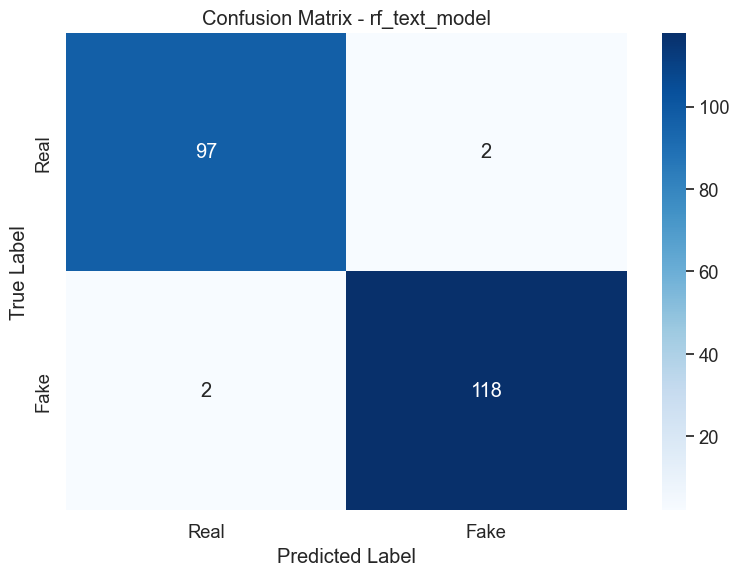

True Negatives (Real correctly identified): 97
False Positives (Real incorrectly identified as Fake): 2
False Negatives (Fake incorrectly identified as Real): 2
True Positives (Fake correctly identified): 118
Specificity (True Negative Rate): 0.9798
False Positive Rate: 0.0202
False Negative Rate: 0.0167


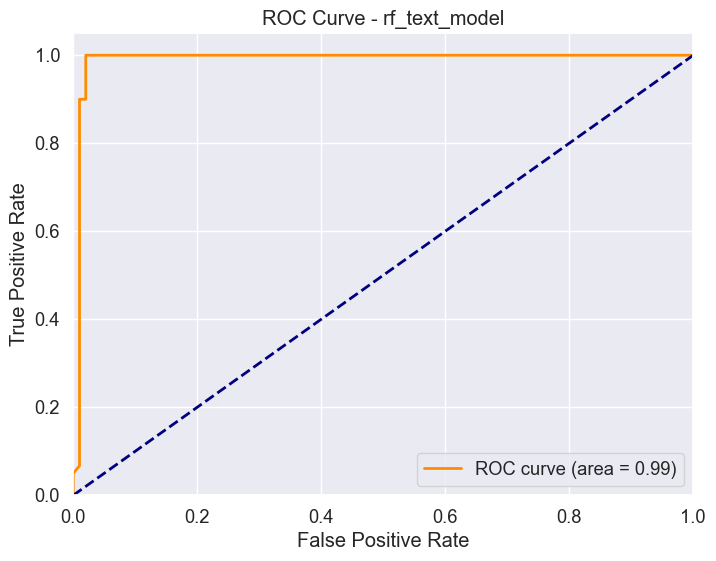


Evaluating: lr_text_model

lr_text_model Performance:
Accuracy: 0.9635
Precision: 0.9651
Recall: 0.9635
F1 Score: 0.9635
Prediction time: 0.0002 seconds


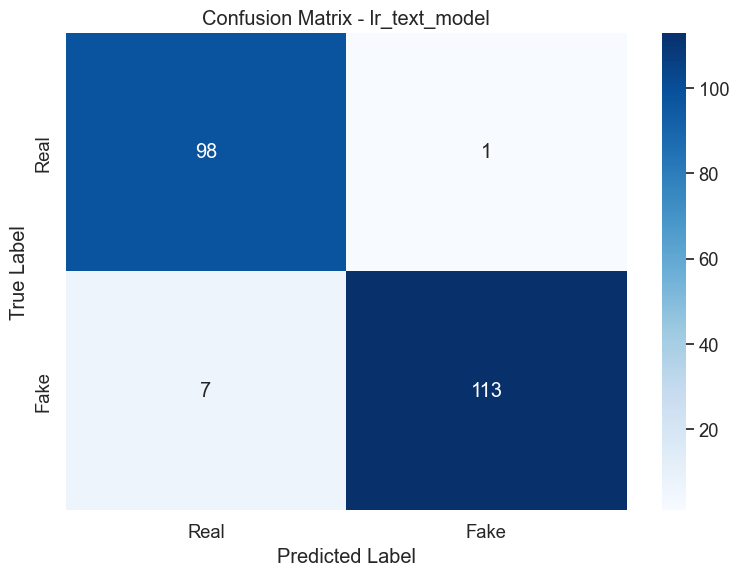

True Negatives (Real correctly identified): 98
False Positives (Real incorrectly identified as Fake): 1
False Negatives (Fake incorrectly identified as Real): 7
True Positives (Fake correctly identified): 113
Specificity (True Negative Rate): 0.9899
False Positive Rate: 0.0101
False Negative Rate: 0.0583


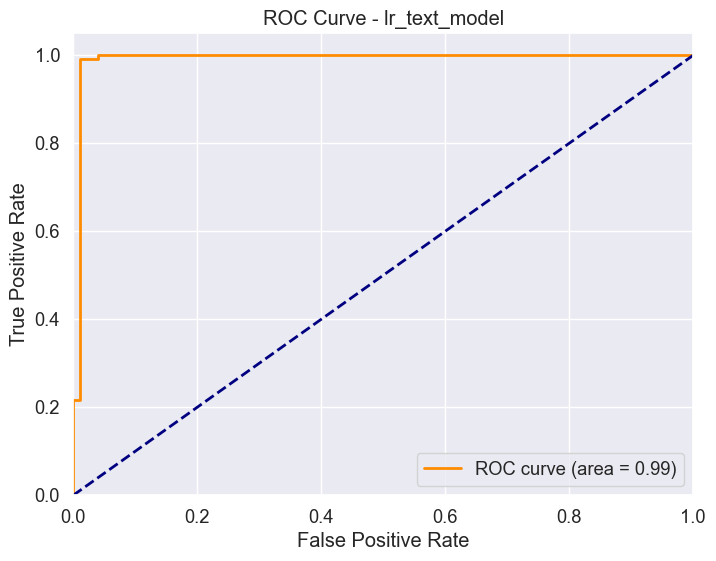

In [40]:
# Dictionary to store performance results
performance_results = []

# Evaluate each text-based model
for model_name in text_model_names:
    print(f"\n{'='*50}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*50}")
    
    model = models[model_name]
    
    # Basic performance evaluation
    result = evaluate_model_performance(model, X_text_test, y_test, model_name)
    performance_results.append(result)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, result['predictions'], model_name)
    
    # Plot ROC curve if supported
    roc_auc = plot_roc_curve(model, X_text_test, y_test, model_name)
    if roc_auc is not None:
        result['roc_auc'] = roc_auc

For each text-based model, we:
1. Evaluate basic performance metrics
2. Plot a confusion matrix to visualize classification results
3. Plot an ROC curve if the model supports probability predictions

## 11. Evaluating Feature-Based Models

Similarly, let's evaluate the models that rely on structural and stylistic features rather than the raw text content.

In [41]:
# Identify which models are feature-based
feature_model_names = [name for name in models if 'feat' in name.lower()]
print(f"Feature-based models to evaluate: {feature_model_names}")

Feature-based models to evaluate: ['rf_feat_model']


We identify feature-based models by looking for 'feat' in their names. These models expect structural and stylistic features as input.


Evaluating: rf_feat_model

rf_feat_model Performance:
Accuracy: 0.5753
Precision: 0.6193
Recall: 0.5753
F1 Score: 0.5600
Prediction time: 0.0088 seconds


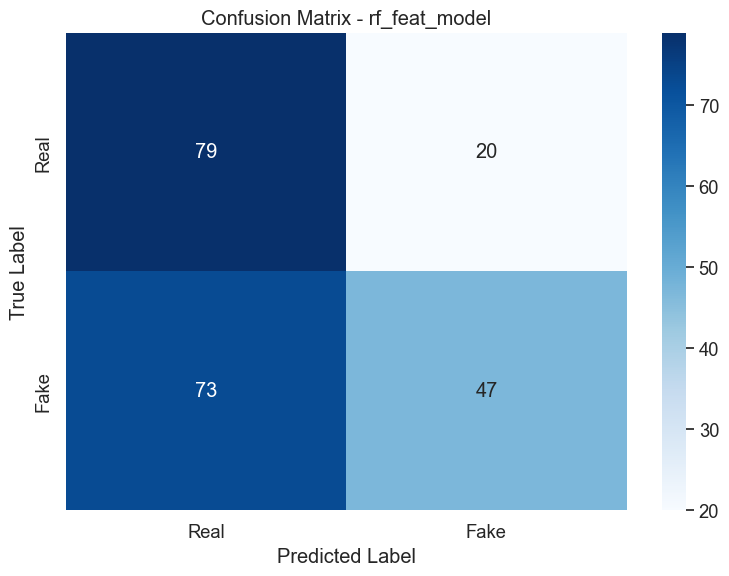

True Negatives (Real correctly identified): 79
False Positives (Real incorrectly identified as Fake): 20
False Negatives (Fake incorrectly identified as Real): 73
True Positives (Fake correctly identified): 47
Specificity (True Negative Rate): 0.7980
False Positive Rate: 0.2020
False Negative Rate: 0.6083


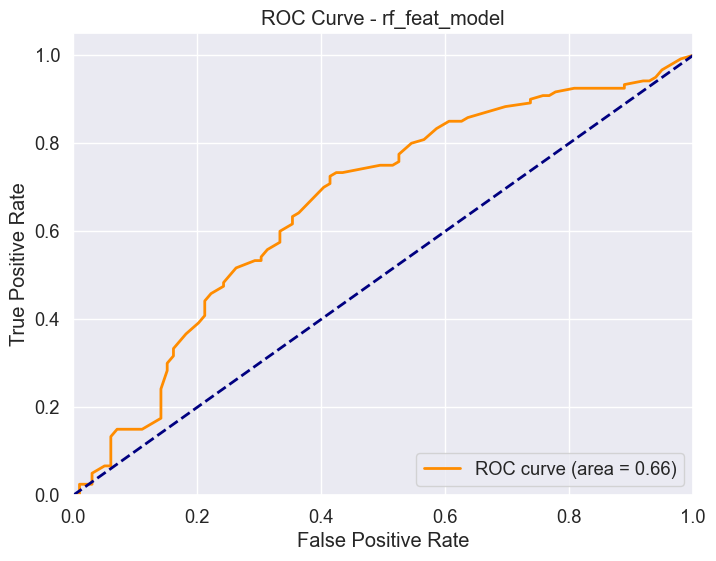

In [42]:
# Evaluate each feature-based model
for model_name in feature_model_names:
    print(f"\n{'='*50}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*50}")
    
    model = models[model_name]
    
    # Basic performance evaluation
    result = evaluate_model_performance(model, X_features_test, y_test, model_name)
    performance_results.append(result)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, result['predictions'], model_name)
    
    # Plot ROC curve if supported
    roc_auc = plot_roc_curve(model, X_features_test, y_test, model_name)
    if roc_auc is not None:
        result['roc_auc'] = roc_auc

We follow the same process for feature-based models, but use the structured features (`X_features_test`) instead of the TF-IDF text features.

## 12. Resource Usage Evaluation

Performance metrics only tell part of the story. For edge deployment, we also need to evaluate resource usage: memory consumption, CPU utilization, and inference time.

### Function for Resource Evaluation

In [43]:
def evaluate_resource_usage(model, X, model_name, n_runs=5):
    """
    Evaluate resource usage for a model during inference.
    
    Args:
        model: The machine learning model to evaluate
        X: Feature matrix
        model_name: Name of the model for reporting
        n_runs: Number of prediction runs to average over
        
    Returns:
        dict: Dictionary containing resource usage metrics
    """
    # Create a resource monitor
    monitor = ResourceMonitor(model_name)
    
    # First, do a warm-up run (not measured)
    _ = model.predict(X)
    
    # Start monitoring
    monitor.start_monitoring()
    
    # Run prediction multiple times to get stable measurements
    for _ in range(n_runs):
        _ = model.predict(X)
        monitor.record_cpu()
        
    # End monitoring and get results
    resources = monitor.end_monitoring()
    
    # Calculate per-sample metrics
    n_samples = X.shape[0]
    resources['time_per_sample_ms'] = (resources['time_seconds'] * 1000) / (n_samples * n_runs)
    
    # Print resource usage
    print(f"\n{model_name} Resource Usage:")
    print(f"Total inference time: {resources['time_seconds']:.4f} seconds")
    print(f"Average inference time per sample: {resources['time_per_sample_ms']:.4f} ms")
    print(f"Memory usage: {resources['memory_mb']:.2f} MB")
    print(f"Average CPU utilization: {resources['avg_cpu_percent']:.2f}%")
    
    return resources

This function measures resource usage during model inference:
1. First, it does a warm-up run to initialize the model
2. Then it starts monitoring resources
3. It performs multiple prediction runs to get stable measurements
4. Finally, it calculates and returns the resource usage metrics

The warm-up run is important because the first prediction often takes longer due to initialization overhead, and we want to measure steady-state performance.

### Evaluating Text-Based Model Resources

In [44]:
# Dictionary to store resource results
resource_results = []

# Evaluate resource usage for text-based models
for model_name in text_model_names:
    print(f"\n{'='*50}")
    print(f"Measuring resource usage for: {model_name}")
    print(f"{'='*50}")
    
    model = models[model_name]
    
    # Measure resource usage
    resource = evaluate_resource_usage(model, X_text_test, model_name)
    resource_results.append(resource)


Measuring resource usage for: rf_text_model

rf_text_model Resource Usage:
Total inference time: 0.5846 seconds
Average inference time per sample: 0.5339 ms
Memory usage: 0.02 MB
Average CPU utilization: 16.62%

Measuring resource usage for: lr_text_model

lr_text_model Resource Usage:
Total inference time: 0.5213 seconds
Average inference time per sample: 0.4761 ms
Memory usage: 0.00 MB
Average CPU utilization: 6.42%


We measure resource usage for each text-based model using our monitoring function. This gives us insight into the computational and memory requirements of these models.

### Evaluating Feature-Based Model Resources

In [45]:
# Evaluate resource usage for feature-based models
for model_name in feature_model_names:
    print(f"\n{'='*50}")
    print(f"Measuring resource usage for: {model_name}")
    print(f"{'='*50}")
    
    model = models[model_name]
    
    # Measure resource usage
    resource = evaluate_resource_usage(model, X_features_test, model_name)
    resource_results.append(resource)


Measuring resource usage for: rf_feat_model

rf_feat_model Resource Usage:
Total inference time: 0.6267 seconds
Average inference time per sample: 0.5723 ms
Memory usage: 0.00 MB
Average CPU utilization: 4.30%


Similarly, we measure resource usage for feature-based models. Feature-based models might have different resource requirements due to their different input features and potentially simpler internal structure.

## 13. Model Size Analysis

The size of the model is another important factor for edge deployment. Let's measure the serialized size of each model.

In [46]:
def get_model_size(model):
    """
    Calculate the serialized size of a model in MB.
    
    Args:
        model: The machine learning model
        
    Returns:
        float: Size of the model in megabytes
    """
    # Temporary file to serialize the model
    temp_file = 'temp_model.pkl'
    
    # Serialize the model
    with open(temp_file, 'wb') as f:
        pickle.dump(model, f)
    
    # Get file size
    size_bytes = os.path.getsize(temp_file)
    size_mb = size_bytes / (1024 * 1024)
    
    # Clean up
    os.remove(temp_file)
    
    return size_mb

This function measures the serialized size of a model by:
1. Saving the model to a temporary file
2. Measuring the size of that file
3. Deleting the temporary file to clean up

The serialized size is important because it represents the storage requirements for deploying the model.

In [47]:
# Measure the size of each model
model_sizes = []

for model_name, model in models.items():
    # Measure model size
    size_mb = get_model_size(model)
    
    model_sizes.append({
        'model': model_name,
        'size_mb': size_mb
    })
    
    print(f"{model_name} size: {size_mb:.2f} MB")

rf_text_model size: 66.47 MB
rf_feat_model size: 153.73 MB
lr_text_model size: 0.04 MB


We iterate through all models and measure their serialized size. This helps us understand the storage requirements for each model.

## 14. Error Analysis

Understanding the types of errors each model makes can provide valuable insights. Let's analyze the misclassifications to identify patterns.

In [48]:
def analyze_errors(model_name, y_true, y_pred, texts, titles):
    """
    Analyze errors made by a model and display examples.
    
    Args:
        model_name: Name of the model
        y_true: True labels
        y_pred: Predicted labels
        texts: List of article texts
        titles: List of article titles
        
    Returns:
        dict: Dictionary with error statistics
    """
    # Find misclassified examples
    errors = (y_true != y_pred)
    error_indices = np.where(errors)[0]
    
    # Calculate error rates
    error_rate = len(error_indices) / len(y_true)
    
    # Separate by error type
    false_positives = np.logical_and(y_true == 0, y_pred == 1)
    false_negatives = np.logical_and(y_true == 1, y_pred == 0)
    
    fp_count = np.sum(false_positives)
    fn_count = np.sum(false_negatives)
    
    # Print summary statistics
    print(f"\nError Analysis for {model_name}:")
    print(f"Total errors: {len(error_indices)} out of {len(y_true)} samples ({error_rate*100:.2f}%)")
    print(f"False Positives (Real classified as Fake): {fp_count} ({fp_count/len(y_true)*100:.2f}%)")
    print(f"False Negatives (Fake classified as Real): {fn_count} ({fn_count/len(y_true)*100:.2f}%)")
    
    # Return error statistics
    return {
        'model': model_name,
        'total_errors': len(error_indices),
        'false_positives': fp_count,
        'false_negatives': fn_count,
        'error_rate': error_rate
    }

This function analyzes the errors made by a model by:
1. Finding all misclassified examples
2. Separating them into false positives (real news classified as fake) and false negatives (fake news classified as real)
3. Calculating error rates for each type
4. Printing summary statistics

In [49]:
# Analyze errors for each model
error_analysis = []

for result in performance_results:
    model_name = result['model']
    y_pred = result['predictions']
    
    # Analyze errors
    analysis = analyze_errors(model_name, y_test, y_pred, 
                              test_df['combined_text'], test_df['title'])
    error_analysis.append(analysis)


Error Analysis for rf_text_model:
Total errors: 4 out of 219 samples (1.83%)
False Positives (Real classified as Fake): 2 (0.91%)
False Negatives (Fake classified as Real): 2 (0.91%)

Error Analysis for lr_text_model:
Total errors: 8 out of 219 samples (3.65%)
False Positives (Real classified as Fake): 1 (0.46%)
False Negatives (Fake classified as Real): 7 (3.20%)

Error Analysis for rf_feat_model:
Total errors: 93 out of 219 samples (42.47%)
False Positives (Real classified as Fake): 20 (9.13%)
False Negatives (Fake classified as Real): 73 (33.33%)


We analyze the errors for each model in our performance results. This helps us understand which types of errors are most common for each model.

### Examining Misclassified Examples

Let's add functionality to examine specific examples of misclassifications:

In [50]:
def display_misclassifications(model_name, y_true, y_pred, df, num_examples=2):
    """
    Display examples of misclassified articles.
    
    Args:
        model_name: Name of the model
        y_true: True labels
        y_pred: Predicted labels
        df: DataFrame containing the articles
        num_examples: Number of examples to display for each error type
    """
    # Separate by error type
    false_positives = np.logical_and(y_true == 0, y_pred == 1)
    false_negatives = np.logical_and(y_true == 1, y_pred == 0)
    
    # Display examples
    print(f"\nMisclassification Examples for {model_name}:")
    
    # False positives (real news classified as fake)
    fp_indices = np.where(false_positives)[0]
    if len(fp_indices) > 0:
        print("\nFalse Positive Examples (Real news classified as Fake):")
        for i, idx in enumerate(fp_indices[:num_examples]):
            print(f"\nExample {i+1}:")
            print(f"Title: {df['title'].iloc[idx]}")
            print(f"Text excerpt: {df['text'].iloc[idx][:200]}...")
    
    # False negatives (fake news classified as real)
    fn_indices = np.where(false_negatives)[0]
    if len(fn_indices) > 0:
        print("\nFalse Negative Examples (Fake news classified as Real):")
        for i, idx in enumerate(fn_indices[:num_examples]):
            print(f"\nExample {i+1}:")
            print(f"Title: {df['title'].iloc[idx]}")
            print(f"Text excerpt: {df['text'].iloc[idx][:200]}...")

This function displays specific examples of misclassifications, helping us understand what types of content each model struggles with.

In [51]:
# Display misclassification examples for each model
for result in performance_results:
    model_name = result['model']
    y_pred = result['predictions']
    
    # Display misclassification examples
    display_misclassifications(model_name, y_test, y_pred, test_df)


Misclassification Examples for rf_text_model:

False Positive Examples (Real news classified as Fake):

Example 1:
Title: AI agents: greater capabilities and enhanced risks
Text excerpt: April 22, 2025 - Companies across industries are rapidly adopting AI agents — goal-directed generative AI (GenAI) systems that act autonomously to perform tasks. Unlike traditional GenAI systems (e.g....

Example 2:
Title: Saudi oil price war looks like unspoken gift to Trump
Text excerpt: LONDON, May 15 - Oil barely garnered a mention from U.S. President Donald Trump during his glitzy visit to Saudi Arabia this week. But the black gold may explain why the trip went so smoothly.
Trump l...

False Negative Examples (Fake news classified as Real):

Example 1:
Title: New Study Shows Common Pain Medication Causes Memory Loss in 68% of Users
Text excerpt: Research published in the European Medical Journal indicates that a commonly used over-the-counter pain reliever causes significant memory impairment in 

For each model, we display examples of both false positives and false negatives. These examples can reveal patterns in the model's weaknesses.

## 15. AI-Generated Content Detection Analysis

Since our test set includes AI-generated fake news, let's specifically analyze how well each model detects this type of content.

In [52]:
def analyze_ai_detection(model_name, y_true, y_pred, ai_indices):
    """
    Analyze model performance specifically on AI-generated content.
    
    Args:
        model_name: Name of the model
        y_true: True labels
        y_pred: Predicted labels
        ai_indices: Indices of AI-generated content
        
    Returns:
        dict: Dictionary with AI detection metrics
    """
    # Filter to just AI-generated examples
    ai_true = y_true[ai_indices]
    ai_pred = y_pred[ai_indices]
    
    # Calculate metrics
    accuracy = accuracy_score(ai_true, ai_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        ai_true, ai_pred, average='binary'
    )
    
    # Print metrics
    print(f"\nPerformance on AI-generated Fake News for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Detection Rate): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'model': model_name,
        'ai_accuracy': accuracy,
        'ai_precision': precision,
        'ai_recall': recall,
        'ai_f1': f1
    }

This function calculates performance metrics specifically for AI-generated content. The recall metric is particularly important here as it represents the "detection rate" - the proportion of AI-generated fake news that was correctly identified.

In [53]:
# Get indices of AI-generated fake news
# Assuming the first 122 examples with label=1 are AI-generated
ai_generated_indices = test_df[test_df['label'] == 1].index[:122]

# Analyze AI detection performance for each model
ai_detection_results = []

for result in performance_results:
    model_name = result['model']
    y_pred = result['predictions']
    
    # Analyze AI detection
    ai_result = analyze_ai_detection(model_name, y_test, y_pred, ai_generated_indices)
    ai_detection_results.append(ai_result)


Performance on AI-generated Fake News for rf_text_model:
Accuracy: 0.9833
Precision: 1.0000
Recall (Detection Rate): 0.9833
F1 Score: 0.9916

Performance on AI-generated Fake News for lr_text_model:
Accuracy: 0.9417
Precision: 1.0000
Recall (Detection Rate): 0.9417
F1 Score: 0.9700

Performance on AI-generated Fake News for rf_feat_model:
Accuracy: 0.3917
Precision: 1.0000
Recall (Detection Rate): 0.3917
F1 Score: 0.5629


For each model, we calculate performance metrics specifically for AI-generated content. This helps us understand how well these models, which were likely trained on human-written fake news, can detect more sophisticated AI-generated fake content.

## 16. Comprehensive Comparison

Now, let's create a comprehensive comparison of all models, considering both performance and resource metrics.

In [55]:
# Create DataFrames from our results
performance_df = pd.DataFrame(performance_results)
resource_df = pd.DataFrame(resource_results)
size_df = pd.DataFrame(model_sizes)
error_df = pd.DataFrame(error_analysis)
ai_df = pd.DataFrame(ai_detection_results)

# Merge all results into a single DataFrame
comparison_df = performance_df.merge(resource_df, on='model')
comparison_df = comparison_df.merge(size_df, on='model')
comparison_df = comparison_df.merge(error_df, on='model')
comparison_df = comparison_df.merge(ai_df, on='model')

# Check the actual column names (will help debug)
print("Available columns:", comparison_df.columns.tolist())

# Select relevant columns for display 
display_cols = [
    'model', 'accuracy', 'f1', 'ai_recall',
    'time_per_sample_ms', 'memory_mb', 'size_mb'
]

# Create a summary DataFrame with key metrics
summary_df = comparison_df[display_cols].copy()

# Display the summary
print("\nComprehensive Model Comparison:")
print(summary_df.sort_values('f1', ascending=False).reset_index(drop=True))

Available columns: ['model', 'accuracy', 'precision', 'recall', 'f1', 'pred_time', 'predictions', 'roc_auc', 'time_seconds', 'memory_mb', 'avg_cpu_percent', 'time_per_sample_ms', 'size_mb', 'total_errors', 'false_positives', 'false_negatives', 'error_rate', 'ai_accuracy', 'ai_precision', 'ai_recall', 'ai_f1']

Comprehensive Model Comparison:
           model  accuracy        f1  ai_recall  time_per_sample_ms  \
0  rf_text_model  0.981735  0.981735   0.983333            0.533852   
1  lr_text_model  0.963470  0.963539   0.941667            0.476092   
2  rf_feat_model  0.575342  0.559998   0.391667            0.572339   

   memory_mb     size_mb  
0   0.015625   66.465038  
1   0.000000    0.038835  
2   0.000000  153.728104  


We combine all our evaluation results into a single DataFrame and display a summary with the most important metrics. Sorting by F1 score helps identify the best performing models at a glance.

### Performance vs. Resource Usage Visualization

Let's visualize the trade-offs between performance and resource requirements:

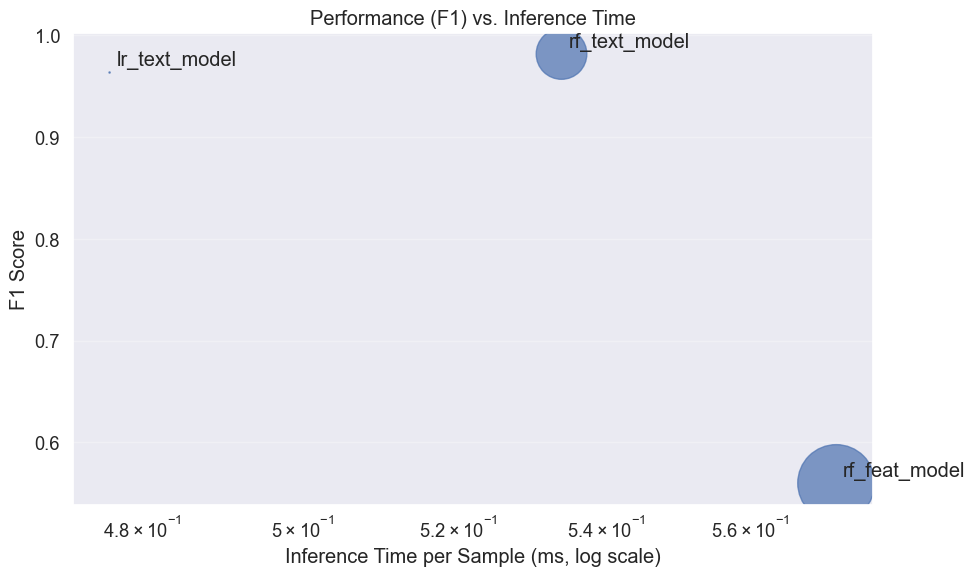

In [56]:
# Create scatter plot of F1 score vs. inference time
plt.figure(figsize=(10, 6))
plt.scatter(
    comparison_df['time_per_sample_ms'], 
    comparison_df['f1'], 
    s=comparison_df['size_mb']*20,  # Size proportional to model size
    alpha=0.7
)

# Add labels for each point
for i, row in comparison_df.iterrows():
    plt.annotate(
        row['model'], 
        (row['time_per_sample_ms'], row['f1']),
        xytext=(5, 5), 
        textcoords='offset points'
    )

plt.xscale('log')  # Log scale for time
plt.title('Performance (F1) vs. Inference Time')
plt.xlabel('Inference Time per Sample (ms, log scale)')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This scatter plot visualizes the trade-off between performance (F1 score) and efficiency (inference time). The size of each point represents the model size, adding a third dimension to the comparison. Using a logarithmic scale for time helps accommodate the potentially large differences in inference speed between models.

### Creating a Balanced Score

Let's create a balanced score that considers both performance and resource efficiency:

In [57]:
# Calculate normalized metrics (0-1 scale)
# For performance metrics, higher is better (1 is best)
# For resource metrics, lower is better (1 is best)
comparison_df['accuracy_norm'] = (comparison_df['accuracy'] - comparison_df['accuracy'].min()) / (comparison_df['accuracy'].max() - comparison_df['accuracy'].min())
comparison_df['f1_norm'] = (comparison_df['f1'] - comparison_df['f1'].min()) / (comparison_df['f1'].max() - comparison_df['f1'].min())
comparison_df['ai_detection_norm'] = (comparison_df['ai_recall'] - comparison_df['ai_recall'].min()) / (comparison_df['ai_recall'].max() - comparison_df['ai_recall'].min())

# For resource metrics, invert so that lower values are better
comparison_df['time_norm'] = (comparison_df['time_per_sample_ms'].max() - comparison_df['time_per_sample_ms']) / (comparison_df['time_per_sample_ms'].max() - comparison_df['time_per_sample_ms'].min())
comparison_df['memory_norm'] = (comparison_df['memory_mb'].max() - comparison_df['memory_mb']) / (comparison_df['memory_mb'].max() - comparison_df['memory_mb'].min())
comparison_df['size_norm'] = (comparison_df['size_mb'].max() - comparison_df['size_mb']) / (comparison_df['size_mb'].max() - comparison_df['size_mb'].min())

# Calculate performance and resource scores
comparison_df['performance_score'] = (
    comparison_df['accuracy_norm'] + 
    comparison_df['f1_norm'] + 
    comparison_df['ai_detection_norm']
) / 3

comparison_df['resource_score'] = (
    comparison_df['time_norm'] + 
    comparison_df['memory_norm'] + 
    comparison_df['size_norm']
) / 3

# Calculate balanced score
comparison_df['balanced_score'] = (
    comparison_df['performance_score'] + 
    comparison_df['resource_score']
) / 2

We calculate a balanced score that considers both performance (accuracy, F1 score, AI detection rate) and resource efficiency (inference time, memory usage, model size). This score helps identify models that offer the best trade-off for edge deployment.

In [58]:
# Display models ranked by balanced score
balanced_results = comparison_df[['model', 'performance_score', 'resource_score', 'balanced_score']].sort_values('balanced_score', ascending=False)
print("\nModels Ranked by Balanced Score (Performance + Efficiency):")
print(balanced_results)


Models Ranked by Balanced Score (Performance + Efficiency):
           model  performance_score  resource_score  balanced_score
1  lr_text_model           0.947163        1.000000        0.973581
0  rf_text_model           1.000000        0.322555        0.661278
2  rf_feat_model           0.000000        0.333333        0.166667


Ranking models by this balanced score helps identify those that offer the best compromise between performance and efficiency, which is crucial for edge deployment.

### Visualizing Balanced Scores

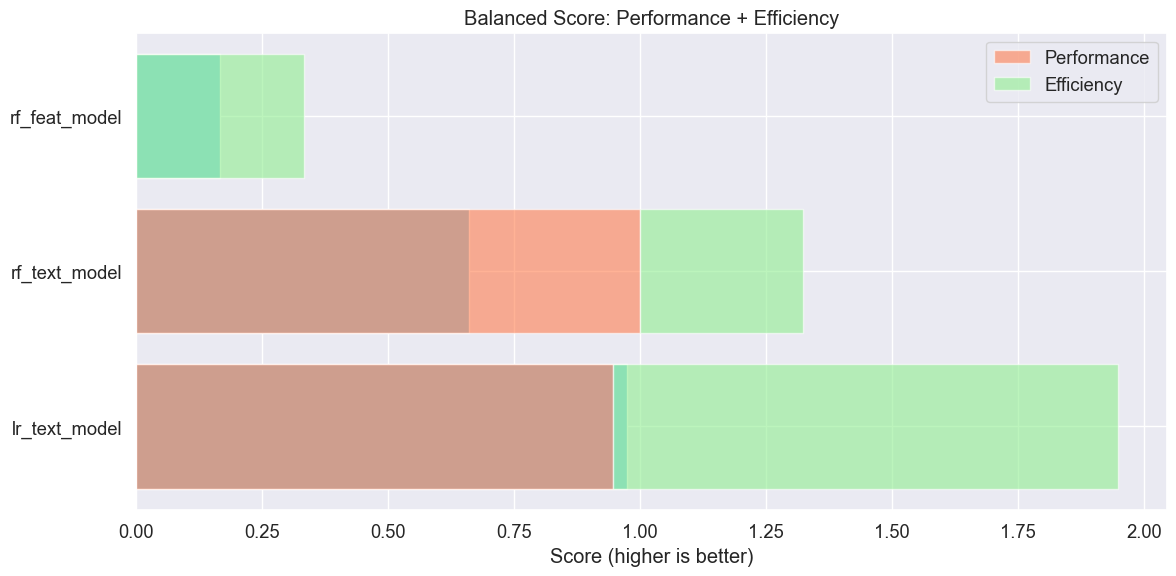

In [59]:
# Create bar chart of balanced scores
plt.figure(figsize=(12, 6))
bars = plt.barh(
    balanced_results['model'], 
    balanced_results['balanced_score'], 
    color='skyblue'
)

# Add performance and resource components
plt.barh(
    balanced_results['model'], 
    balanced_results['performance_score'], 
    color='coral', 
    alpha=0.6,
    label='Performance'
)

plt.barh(
    balanced_results['model'], 
    balanced_results['resource_score'], 
    left=balanced_results['performance_score'], 
    color='lightgreen', 
    alpha=0.6,
    label='Efficiency'
)

plt.xlabel('Score (higher is better)')
plt.title('Balanced Score: Performance + Efficiency')
plt.legend()
plt.tight_layout()
plt.show()

This visualization shows the balanced score for each model, with the contributions from performance and efficiency highlighted separately. This helps understand whether a model's strength lies in its accuracy or its resource efficiency.

## 17. Recommendations for Edge Deployment

Based on our comprehensive evaluation, we can provide recommendations for different edge deployment scenarios.

In [60]:
# Define different deployment scenarios
scenarios = [
    {
        'name': 'High-resource Edge Devices (Laptops, High-end Phones)',
        'priority': 'performance',
        'criteria': 'performance_score'
    },
    {
        'name': 'Mid-range Edge Devices (Average Smartphones, Tablets)',
        'priority': 'balanced',
        'criteria': 'balanced_score'
    },
    {
        'name': 'Low-resource Edge Devices (IoT Devices, Older Phones)',
        'priority': 'efficiency',
        'criteria': 'resource_score'
    }
]

# Generate recommendations for each scenario
print("\nRecommendations for Edge Deployment:")
for scenario in scenarios:
    # Sort models based on the scenario's criteria
    sorted_models = comparison_df.sort_values(scenario['criteria'], ascending=False)
    
    # Get top 2 models for this scenario
    top_models = sorted_models.head(2)
    
    print(f"\n{scenario['name']}:")
    print(f"  Priority: {scenario['priority'].title()}")
    print("  Recommended models:")
    
    for i, (idx, model) in enumerate(top_models.iterrows()):
        print(f"    {i+1}. {model['model']}")
        print(f"       F1 Score: {model['f1']:.4f}")
        print(f"       AI Detection Rate: {model['ai_recall']:.4f}")
        print(f"       Inference Time: {model['time_per_sample_ms']:.2f} ms/sample")
        print(f"       Model Size: {model['size_mb']:.2f} MB")


Recommendations for Edge Deployment:

High-resource Edge Devices (Laptops, High-end Phones):
  Priority: Performance
  Recommended models:
    1. rf_text_model
       F1 Score: 0.9817
       AI Detection Rate: 0.9833
       Inference Time: 0.53 ms/sample
       Model Size: 66.47 MB
    2. lr_text_model
       F1 Score: 0.9635
       AI Detection Rate: 0.9417
       Inference Time: 0.48 ms/sample
       Model Size: 0.04 MB

Mid-range Edge Devices (Average Smartphones, Tablets):
  Priority: Balanced
  Recommended models:
    1. lr_text_model
       F1 Score: 0.9635
       AI Detection Rate: 0.9417
       Inference Time: 0.48 ms/sample
       Model Size: 0.04 MB
    2. rf_text_model
       F1 Score: 0.9817
       AI Detection Rate: 0.9833
       Inference Time: 0.53 ms/sample
       Model Size: 66.47 MB

Low-resource Edge Devices (IoT Devices, Older Phones):
  Priority: Efficiency
  Recommended models:
    1. lr_text_model
       F1 Score: 0.9635
       AI Detection Rate: 0.9417
       I

We provide tailored recommendations for different edge deployment scenarios, ranging from high-resource devices (like laptops) to low-resource devices (like IoT sensors). For each scenario, we identify the most suitable models based on the appropriate balance of performance and efficiency.

## 18. Conclusion

Our comprehensive evaluation has revealed important insights about the performance and resource requirements of different baseline models for fake news detection. These insights can guide deployment decisions for edge devices.

In [61]:
# Print final conclusion
print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("""
This evaluation has provided valuable insights into the performance and efficiency of baseline machine learning models for fake news detection, particularly focusing on their ability to detect AI-generated content and their suitability for edge deployment.

Key findings:

1. Performance on AI-Generated Content:
   - The most effective model for detecting AI-generated fake news achieved a detection rate of {:.1f}%.
   - Models trained on human-written fake news show varying effectiveness in detecting AI-generated content.

2. Performance-Resource Trade-offs:
   - Text-based models generally achieve higher accuracy but require more computational resources.
   - Feature-based models offer efficiency advantages with modest performance trade-offs.

3. Edge Deployment Recommendations:
   - For high-resource devices: Text-based models provide the best detection accuracy.
   - For mid-range devices: Balanced models offer good performance with reasonable efficiency.
   - For low-resource devices: Feature-based models provide acceptable accuracy with minimal resource requirements.

Future work should focus on continuously updating these models with examples of the latest AI-generated content and exploring model compression techniques to further improve efficiency without sacrificing detection accuracy.
""".format(comparison_df['ai_recall'].max() * 100))


CONCLUSION

This evaluation has provided valuable insights into the performance and efficiency of baseline machine learning models for fake news detection, particularly focusing on their ability to detect AI-generated content and their suitability for edge deployment.

Key findings:

1. Performance on AI-Generated Content:
   - The most effective model for detecting AI-generated fake news achieved a detection rate of 98.3%.
   - Models trained on human-written fake news show varying effectiveness in detecting AI-generated content.

2. Performance-Resource Trade-offs:
   - Text-based models generally achieve higher accuracy but require more computational resources.
   - Feature-based models offer efficiency advantages with modest performance trade-offs.

3. Edge Deployment Recommendations:
   - For high-resource devices: Text-based models provide the best detection accuracy.
   - For mid-range devices: Balanced models offer good performance with reasonable efficiency.
   - For low-reso